<a href="https://colab.research.google.com/github/HughYau/Research-with-Python/blob/main/Replication%20Archive/Neoclassical_in_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras
import numpy as np 
import os
from tqdm import trange

# Switch of unnecessary TF warning messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
###############################################################################
################################## Parameters #################################
###############################################################################

gamma = tf.constant(2.0)           # Curvature of the utility function
rho   = tf.constant(0.04)          # Discount rate
A      = tf.constant(0.5)          # TFP
alpha = tf.constant(0.36)          # Returns to scale
delta = tf.constant(0.05)          # Depreciation Rate of Capital

batchSize = 1000                   # Batch Size
number_epochs = 200000            # Number of epochs
lowest_iteration = 0
min_loss = 100000

kMin = 0.1                         # lower bound of sample interval
kMax = 10.0                        # upper bound of sample interval

gridSize = 10000                  # Plotting grid

# Set global seed
tf.random.set_seed(42)
np.random.seed(42)

# Value function initial guess
VFInitGuess = -60

# Neural network optimizer
optimizer = keras.optimizers.Adam()

# ergodic distribution estimation
nBurnedIter = 0                    # number of periods iterated to move away from starting point (called B1 in the paper)

In [ ]:
###############################################################################
######################## Value Function Neural Network ########################
###############################################################################

def NeuralNet(nHidden = 3, nNeurons = 8, initGuess = 0):
    model = keras.models.Sequential()

    # Input layer
    model.add(keras.layers.Dense(nNeurons, activation = "tanh", input_dim = 1))

    # Hiden layers
    for layer in range(nHidden - 1):
        model.add(keras.layers.Dense(nNeurons, activation = "tanh"))

    # Output layer
    model.add(keras.layers.Dense(1,bias_initializer = keras.initializers.Constant(value = initGuess)))
    return model

In [ ]:
# dt = 0.1
def HJB(k_capital, V, C):
    VPrime = tf.gradients(V(k_capital), k_capital)[0]
    # VPrimemax = tf.maximum(VPrime, 1E-7)		# dV/dk

    Y = A * tf.pow(k_capital, alpha)				# Output

    I = Y - tf.exp(C(k_capital))					# Investment

    muK = I - delta * k_capital  					# Capital drift

    U = tf.pow(tf.exp(C(k_capital)), 1-gamma) / (1-gamma) 	# Utility
    # HJB = U - rho * V(k_capital) + tf.multiply(tf.stop_gradient(VPrimemax), muK)
    HJB = U - rho * V(k_capital) + tf.multiply(tf.stop_gradient(VPrime), muK)
    return HJB 

def ergodic_distribution(k_capital, V, C): 
    # iterate the points to estimate the ergodic distribution
    for i in range(nBurnedIter):  
        VPrime = tf.gradients(V(k_capital), k_capital)[0]
        VPrimemax = tf.maximum(VPrime, 1E-7)		    # dV/dk
        Y = A * tf.pow(k_capital, alpha)				# Output
        I = Y - tf.exp(C(k_capital)) 				    # Investment
        dK_dt = I - delta * k_capital  					# Capital drift
        k_capital = k_capital + tf.math.multiply(dt , dK_dt)    # k(t+1) = k(t) + dt*dK_dt
    return k_capital


def boundary_condition_ergodic_1_step (k_capital, V, C):
    VPrime = tf.gradients(V(k_capital), k_capital)[0]
    VPrimemax = tf.maximum(VPrime, 1E-7)		# dV/dk
    Y = A * tf.pow(k_capital, alpha)			# Output
    C = tf.exp(C(k_capital))        			# Consumption
    I = Y - C 									# Investment
    dK_dt = I - delta * k_capital  				# Capital drift
     
    dt = 0.1
    k_capital_t_plus_one = k_capital + tf.math.multiply(dt , dK_dt)
    # we require kmin < k (t + 1) < kMax 
    error_lowerbound = tf.math.maximum(tf.constant([kMin]) - k_capital_t_plus_one, 0)
    error_upperbound = tf.math.maximum(k_capital_t_plus_one - tf.constant([kMax]), 0)
    error = error_lowerbound + error_upperbound
    return error

def boundary_condition(k_capital, V, C):
    Y = A * tf.pow(k_capital, alpha)    # Output
    I = Y - tf.exp(C(k_capital)) 				# Investment
    dK_dt = I - delta * k_capital  				# Capital drift

    epsilon = 1                                 # values close enought to 0 can't have decreasing capital

    error = tf.where((k_capital < epsilon) & (dK_dt < 0) , dK_dt, 0)
    return error

def C_error(k_capital, V, C):
    VPrime = tf.gradients(V(k_capital), k_capital)[0]
    VPrimemax = tf.maximum(VPrime, 1E-7)
    C_err = tf.pow(VPrimemax, (-1/gamma)) - tf.exp(C(k_capital))
    return C_err

def Loss_function(batchSize):
    k_capital = tf.random.uniform(shape = (batchSize,1), minval = kMin, maxval = kMax)
    ergodic_k_capital = ergodic_distribution(k_capital, VF, CF)
    errorV = HJB(ergodic_k_capital, VF, CF)
    errorC = C_error(ergodic_k_capital, VF, CF)
    # errorB = boundary_condition_ergodic_1_step(ergodic_k_capital, VF, CF)
    errorB = boundary_condition(ergodic_k_capital, VF, CF)

    lossV = tf.reduce_mean(tf.square(errorV))
    lossC = tf.reduce_mean(tf.square(errorC))
    lossB = tf.reduce_mean(tf.square(errorB))
    total_loss = lossV + lossC + lossB
    return lossV, lossC, lossB, total_loss 

In [ ]:
###############################################################################
################################ Training Step ################################
###############################################################################

# Need decorator to run in graph mode instead of eager exectution
@tf.function
def training_step():
    with tf.GradientTape(persistent = True) as tape:
        lossV, lossC, lossB, total_loss  = Loss_function(batchSize)
    gradsV = tape.gradient(total_loss, thetaVF)
    gradsC = tape.gradient(total_loss, thetaCF)
    optimizer.apply_gradients(zip(gradsV, thetaVF))
    optimizer.apply_gradients(zip(gradsC, thetaCF))
    return lossV, lossC, lossB, total_loss

###############################################################################
################################ Training Loop ################################
###############################################################################

def train_model(epochs, min_loss):
    lossesV = []
    lossesC = []
    lossesB = []
    total_losses = []

    # auxiliar NN that keeps track of the best approximation so far
    best_VF = tf.keras.models.clone_model(VF)
    best_CF = tf.keras.models.clone_model(CF)       
       
        
    # set the first loss equal to infinity
    min_loss = float("inf")         
    for epoch in trange(epochs):
#         if epoch > 50000:
#             nBurnedIter = 2   
        lossV, lossC, lossB, total_loss = training_step()
        if (total_loss < min_loss):
            lowest_iteration = epoch
            min_loss = total_loss
            best_VF.set_weights(VF.get_weights())
            best_CF.set_weights(CF.get_weights())
            print("\n best loss: \t", min_loss.numpy(), end="\r")
        lossesV.append(lossV.numpy())
        lossesC.append(lossC.numpy())
        lossesB.append(lossB.numpy())
        total_losses.append(total_loss.numpy())

    return lossesV, lossesC, lossesB, total_losses, lowest_iteration, min_loss, best_VF, best_CF

###############################################################################
################################### Running ###################################
###############################################################################

# Set up neural network
VF = NeuralNet(initGuess = VFInitGuess)
CF = NeuralNet()

# Define trainable network parameters
thetaVF = VF.trainable_variables
thetaCF = CF.trainable_variables

# Run Model (and output loss evolution) 
lossesV, lossesC, lossesB, total_losses, min_loss_iteration, minimum_loss, best_VF, best_CF = train_model(number_epochs, min_loss)

VF.set_weights(best_VF.get_weights())
CF.set_weights(best_CF.get_weights())

# print(results[2])
# print(results[3])
print('\n')
print("Value error: ", lossesV[-1])
print("Consumption error : ", lossesC[-1])
print("Boundary error : ", lossesB[-1])
print("Sum of errors: ", total_losses[-1])


  0%|                                                                                       | 0/200000 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

  0%|                                                                            | 35/200000 [00:00<1:09:17, 48.10it/s]


 best loss: 	 241.51213
 best loss: 	 161.10217
 best loss: 	 126.38845
 best loss: 	 104.25682
 best loss: 	 92.10076
 best loss: 	 73.563644
 best loss: 	 71.58051
 best loss: 	 59.71651
 best loss: 	 56.347683
 best loss: 	 53.90508
 best loss: 	 46.579685
 best loss: 	 43.467323
 best loss: 	 39.788246
 best loss: 	 36.41416
 best loss: 	 30.905115
 best loss: 	 28.330847
 best loss: 	 27.344166
 best loss: 	 24.822132
 best loss: 	 23.166964
 best loss: 	 21.906836
 best loss: 	 19.583055
 best loss: 	 19.117971
 best loss: 	 17.034903
 best loss: 	 16.376894
 best loss: 	 15.477005
 best loss: 	 14.338328
 best loss: 	 13.331633
 best loss: 	 12.293451
 best loss: 	 11.775282
 best loss: 	 10.944416
 best loss: 	 10.675291
 best loss: 	 9.603096
 best loss: 	 9.186529
 best loss: 	 8.584996
 best loss: 	 8.364331
 best loss: 	 7.960615
 best loss: 	 7.6666703
 best loss: 	 7.4625664
 best loss: 	 6.9389024
 best loss: 	 6.802558
 best loss: 	 6.7850785
 best loss: 	 6.6649423
 b

  0%|                                                                            | 124/200000 [00:01<18:35, 179.19it/s]

5.9178834
 best loss: 	 5.908124
 best loss: 	 5.82701
 best loss: 	 5.8091245
 best loss: 	 5.7874155
 best loss: 	 5.761122
 best loss: 	 5.725831
 best loss: 	 5.663472
 best loss: 	 5.59326
 best loss: 	 5.526107
 best loss: 	 5.5161457
 best loss: 	 5.4585195
 best loss: 	 5.3740735
 best loss: 	 5.3654447
 best loss: 	 5.3544474
 best loss: 	 5.3237104
 best loss: 	 5.312404
 best loss: 	 5.2765965
 best loss: 	 5.2015414
 best loss: 	 5.191465
 best loss: 	 5.179279
 best loss: 	 5.172535
 best loss: 	 5.1573887
 best loss: 	 5.141456
 best loss: 	 5.131438
 best loss: 	 5.1165767
 best loss: 	 5.0916824
 best loss: 	 5.0562425
 best loss: 	 5.0460978
 best loss: 	 5.031248
 best loss: 	 5.016696
 best loss: 	 4.9870777
 best loss: 	 4.9847527


  0%|                                                                            | 208/200000 [00:01<12:17, 270.82it/s]


 best loss: 	 4.9672384
 best loss: 	 4.9177585
 best loss: 	 4.8981504
 best loss: 	 4.8836794
 best loss: 	 4.875393
 best loss: 	 4.8551335
 best loss: 	 4.8185945
 best loss: 	 4.7897186
 best loss: 	 4.781637
 best loss: 	 4.7795815
 best loss: 	 4.7337055
 best loss: 	 4.7132998
 best loss: 	 4.7007513
 best loss: 	 4.6750236
 best loss: 	 4.653993
 best loss: 	 4.6535354
 best loss: 	 4.638139
 best loss: 	 4.6377816
 best loss: 	 4.612849
 best loss: 	 4.6091
 best loss: 	 4.5897665
 best loss: 	 4.5871253
 best loss: 	 4.580198
 best loss: 	 4.568827
 best loss: 	 4.5544677
 best loss: 	 4.542612
 best loss: 	 4.531645
 best loss: 	 4.530337
 best loss: 	 4.506176
 best loss: 	 4.5012894
 best loss: 	 4.4887443


  0%|▏                                                                           | 360/200000 [00:01<06:38, 501.23it/s]


 best loss: 	 4.460388
 best loss: 	 4.449457
 best loss: 	 4.3986244
 best loss: 	 4.3828626
 best loss: 	 4.3781652
 best loss: 	 4.3625493
 best loss: 	 4.3374505
 best loss: 	 4.3286304
 best loss: 	 4.3279233
 best loss: 	 4.3006215
 best loss: 	 4.2868958
 best loss: 	 4.2683825
 best loss: 	 4.265079
 best loss: 	 4.263489
 best loss: 	 4.2539263
 best loss: 	 4.2346716
 best loss: 	 4.2301574
 best loss: 	 4.213482
 best loss: 	 4.1946135
 best loss: 	 4.1893167
 best loss: 	 4.183346
 best loss: 	 4.1820197
 best loss: 	 4.1730947
 best loss: 	 4.1687946
 best loss: 	 4.16605
 best loss: 	 4.161494
 best loss: 	 4.1551967
 best loss: 	 4.140369
 best loss: 	 4.136206


  0%|▏                                                                           | 627/200000 [00:01<03:49, 870.46it/s]


 best loss: 	 4.1123796
 best loss: 	 4.1086235
 best loss: 	 4.093183
 best loss: 	 4.0894017
 best loss: 	 4.0893826
 best loss: 	 4.0723176
 best loss: 	 4.0629883
 best loss: 	 4.05706
 best loss: 	 4.052826
 best loss: 	 4.0252733
 best loss: 	 4.0238423
 best loss: 	 3.9948444
 best loss: 	 3.9888628
 best loss: 	 3.984265
 best loss: 	 3.984161
 best loss: 	 3.9617963
 best loss: 	 3.9469097
 best loss: 	 3.9387665
 best loss: 	 3.927431
 best loss: 	 3.925409
 best loss: 	 3.9165084
 best loss: 	 3.9152079
 best loss: 	 3.8880336
 best loss: 	 

  0%|▎                                                                           | 768/200000 [00:01<03:23, 978.55it/s]

3.8815656
 best loss: 	 3.8770804
 best loss: 	 3.868912
 best loss: 	 3.8476834
 best loss: 	 3.846467
 best loss: 	 3.84263
 best loss: 	 3.8390589
 best loss: 	 3.8375032
 best loss: 	 3.816918
 best loss: 	 3.8054445
 best loss: 	 3.802577
 best loss: 	 3.7993567
 best loss: 	 3.7959428
 best loss: 	 3.7788994
 best loss: 	 3.763368
 best loss: 	 3.7632763
 best loss: 	 3.7135518
 best loss: 	 3.7066875
 best loss: 	 3.7022703


  1%|▍                                                                         | 1276/200000 [00:02<02:24, 1378.05it/s]


 best loss: 	 3.6333814
 best loss: 	 3.6297753
 best loss: 	 3.5851936
 best loss: 	 3.565194
 best loss: 	 3.5319686


  1%|▌                                                                         | 1601/200000 [00:02<02:16, 1457.98it/s]


 best loss: 	 3.52293
 best loss: 	 3.4980204
 best loss: 	 3.4845998
 best loss: 	 3.4754486
 best loss: 	 3.4573267
 best loss: 	 3.4402702
 best loss: 	 3.4324484
 best loss: 	 3.425137
 best loss: 	 3.4108317


  1%|▋                                                                         | 1946/200000 [00:02<02:09, 1531.66it/s]


 best loss: 	 3.3950853
 best loss: 	 3.3566604
 best loss: 	 3.3474834
 best loss: 	 3.3402102
 best loss: 	 3.3220956
 best loss: 	 3.3070354


  1%|▉                                                                         | 2627/200000 [00:03<02:02, 1612.24it/s]


 best loss: 	 3.2164233
 best loss: 	 3.1840549
 best loss: 	 3.1558115


  1%|█                                                                         | 2959/200000 [00:03<02:12, 1491.24it/s]


 best loss: 	 3.1397026
 best loss: 	 3.1328273
 best loss: 	 3.1143425


  2%|█▎                                                                        | 3427/200000 [00:03<02:14, 1457.28it/s]


 best loss: 	 3.0503588
 best loss: 	 3.023535
 best loss: 	 3.017074
 best loss: 	 3.0157576
 best loss: 	 3.0057895


  2%|█▍                                                                        | 3742/200000 [00:03<02:15, 1451.58it/s]


 best loss: 	 2.9722855
 best loss: 	 2.946378
 best loss: 	 2.9346707
 best loss: 	 2.8993385


  2%|█▌                                                                        | 4246/200000 [00:04<02:05, 1565.38it/s]


 best loss: 	 2.8393512
 best loss: 	 2.8373802
 best loss: 	 2.8249006
 best loss: 	 2.8214242


  2%|█▊                                                                        | 4734/200000 [00:04<02:03, 1585.54it/s]


 best loss: 	 2.7750654
 best loss: 	 2.766865
 best loss: 	 2.7665377
 best loss: 	 2.7462008
 best loss: 	 2.7426772
 best loss: 	 2.7279983


  3%|█▊                                                                        | 5057/200000 [00:04<02:01, 1601.75it/s]


 best loss: 	 2.6852825
 best loss: 	 2.6533072
 best loss: 	 2.6457078
 best loss: 	 2.6431775
 best loss: 	 2.6327062
 best loss: 	 

  3%|█▉                                                                        | 5388/200000 [00:04<02:04, 1563.44it/s]

2.6245766
 best loss: 	 2.608749
 best loss: 	 2.576455
 best loss: 	 2.5419545


  3%|██                                                                        | 5732/200000 [00:05<02:03, 1577.37it/s]


 best loss: 	 2.4808109
 best loss: 	 2.470775
 best loss: 	 2.456771
 best loss: 	 2.445897
 best loss: 	 2.4258246
 best loss: 	 2.4063807
 best loss: 	 2.3716571
 best loss: 	 2.3625367


  3%|██▏                                                                       | 6059/200000 [00:05<02:05, 1547.23it/s]


 best loss: 	 2.3355987
 best loss: 	 2.277894
 best loss: 	 2.2736566
 best loss: 	 2.2713091
 best loss: 	 2.2611895
 best loss: 	 2.2054002
 best loss: 	 2.2045052
 best loss: 	 2.1884718
 best loss: 	 2.1688352


  3%|██▎                                                                       | 6382/200000 [00:05<02:06, 1529.69it/s]


 best loss: 	 2.1561966
 best loss: 	 2.1492426
 best loss: 	 2.1045215
 best loss: 	 2.1031644
 best loss: 	 2.073462
 best loss: 	 2.011429
 best loss: 	 1.9949605
 best loss: 	 1.938813
 best loss: 	 1.934693
 best loss: 	 1.9326373


  3%|██▍                                                                       | 6689/200000 [00:05<02:09, 1488.50it/s]


 best loss: 	 1.9102659
 best loss: 	 1.9024436
 best loss: 	 1.8859295
 best loss: 	 1.8796265
 best loss: 	 1.865537
 best loss: 	 1.8540101
 best loss: 	 1.8381476
 best loss: 	 1.7957491
 best loss: 	 1.7927096
 best loss: 	 1.787387
 best loss: 	 1.7727088
 best loss: 	 1.7179317
 best loss: 	 1.7156461
 best loss: 	 1.7007129
 best loss: 	 1.672776
 best loss: 	 1.6626287
 best loss: 	 1.6518781
 best loss: 	 1.6279103
 best loss: 	 1.6235245


  3%|██▌                                                                       | 6995/200000 [00:06<02:16, 1416.90it/s]


 best loss: 	 1.5796899
 best loss: 	 1.5662102
 best loss: 	 1.5511919
 best loss: 	 1.5250987
 best loss: 	 1.5244751
 best loss: 	 1.4990503
 best loss: 	 1.4738052
 best loss: 	 1.4577618
 best loss: 	 1.4567521
 best loss: 	 1.4474518
 best loss: 	 1.4217895
 best loss: 	 1.3966978
 best loss: 	 1.3867677
 best loss: 	 1.3704234
 best loss: 	 1.3491759


  4%|██▋                                                                       | 7329/200000 [00:06<02:09, 1483.07it/s]


 best loss: 	 1.3073745
 best loss: 	 1.2964798
 best loss: 	 1.2828666
 best loss: 	 1.2753961
 best loss: 	 1.2421899
 best loss: 	 1.2292484


  4%|██▊                                                                       | 7633/200000 [00:06<02:07, 1503.61it/s]


 best loss: 	 1.207862
 best loss: 	 1.2025347
 best loss: 	 1.1800778
 best loss: 	 1.172431
 best loss: 	 1.1608772
 best loss: 	 1.1382748
 best loss: 	 1.1344923
 best loss: 	 1.1041868


  4%|██▉                                                                       | 7971/200000 [00:06<02:04, 1540.18it/s]


 best loss: 	 1.0604697
 best loss: 	 1.0598698
 best loss: 	 1.0516816
 best loss: 	 1.0225911
 best loss: 	 1.0136098
 best loss: 	 0.9791351
 best loss: 	 0.9576122


  4%|███                                                                       | 8292/200000 [00:06<02:06, 1521.29it/s]


 best loss: 	 0.951058
 best loss: 	 0.9475965
 best loss: 	 0.9246286
 best loss: 	 0.9159775
 best loss: 	 0.9095315
 best loss: 	 0.908327
 best loss: 	 0.9014608
 best loss: 	 0.8476659
 best loss: 	 0.8416351


  4%|███▏                                                                      | 8454/200000 [00:06<02:09, 1483.56it/s]


 best loss: 	 0.8325667
 best loss: 	 0.8266816
 best loss: 	 0.823156
 best loss: 	 0.8138513
 best loss: 	 0.8072952
 best loss: 	 0.7962027
 best loss: 	 0.78539693
 best loss: 	 0.7734616
 best loss: 	 0.7533116
 best loss: 	 0.7434887
 best loss: 	 0.742737
 best loss: 	 0.73468584


  4%|███▏                                                                      | 8765/200000 [00:07<02:10, 1468.11it/s]


 best loss: 	 0.70919806
 best loss: 	 0.6887371
 best loss: 	 0.6834764
 best loss: 	 0.67903316
 best loss: 	 0.67643744
 best loss: 	 0.673804
 best loss: 	 0.66451603
 best loss: 	 0.6616599
 best loss: 	 0.6580718
 best loss: 	 0.65064794
 best loss: 	 0.64612037
 best loss: 	 0.6299069


  5%|███▎                                                                      | 9080/200000 [00:07<02:06, 1507.15it/s]


 best loss: 	 0.603137
 best loss: 	 0.60179377
 best loss: 	 0.60036284
 best loss: 	 0.5943796


  5%|███▍                                                                      | 9403/200000 [00:07<02:02, 1555.71it/s]


 best loss: 	 0.5848062


  7%|████▊                                                                    | 13266/200000 [00:09<01:54, 1631.54it/s]


 best loss: 	 0.56762373
 best loss: 	 0.56032896
 best loss: 	 0.5602599
 best loss: 	 0.5586762
 best loss: 	 0.5559807
 best loss: 	 0.5444882
 best loss: 	 0.5394157
 best loss: 	 0.5355596
 best loss: 	 0.53035486


  7%|████▉                                                                    | 13588/200000 [00:10<02:00, 1550.91it/s]


 best loss: 	 0.52107227
 best loss: 	 0.520416
 best loss: 	 0.5178845
 best loss: 	 0.51788443
 best loss: 	 0.514157
 best loss: 	 0.50807315
 best loss: 	 0.49639675
 best loss: 	 0.49507007
 best loss: 	 0.494553
 best loss: 	 0.4921055
 best loss: 	 0.48803887


  7%|█████                                                                    | 13744/200000 [00:10<02:07, 1466.46it/s]


 best loss: 	 0.47083935
 best loss: 	 0.46310836
 best loss: 	 0.4615033
 best loss: 	 0.44776112
 best loss: 	 0.44435498
 best loss: 	 0.43759483
 best loss: 	 0.43185252


  7%|█████▏                                                                   | 14056/200000 [00:10<02:05, 1485.91it/s]


 best loss: 	 0.42568207
 best loss: 	 0.4248164
 best loss: 	 0.4152038
 best loss: 	 0.41504848
 best loss: 	 0.40349355
 best loss: 	 0.39581856
 best loss: 	 0.39297703
 best loss: 	 0.39277887
 best loss: 	 0.38861644
 best loss: 	 0.3824628
 best loss: 	 0.38193431
 best loss: 	 0.3804946


  7%|█████▏                                                                   | 14371/200000 [00:10<02:03, 1506.75it/s]


 best loss: 	 0.35928458
 best loss: 	 0.3408972
 best loss: 	 0.33387002
 best loss: 	 0.33182955
 best loss: 	 0.32973677
 best loss: 	 0.3273543
 best loss: 	 0.32627186


  7%|█████▎                                                                   | 14684/200000 [00:10<02:03, 1501.34it/s]


 best loss: 	 0.32010344
 best loss: 	 0.31892335
 best loss: 	 0.31047487
 best loss: 	 0.30782092
 best loss: 	 0.3076086
 best loss: 	 0.30355245
 best loss: 	 0.3033299
 best loss: 	 0.2997276
 best loss: 	 0.2967999
 best loss: 	 0.2896061
 best loss: 	 0.28827006
 best loss: 	 0.2852599
 best loss: 	 0.28478667
 best loss: 	 0.28424296
 best loss: 	 0.282937


  7%|█████▍                                                                   | 14988/200000 [00:11<02:08, 1445.33it/s]


 best loss: 	 0.2820903
 best loss: 	 0.2787367
 best loss: 	 0.27399042
 best loss: 	 0.27369085
 best loss: 	 0.2631491
 best loss: 	 0.25827393
 best loss: 	 0.2565292
 best loss: 	 0.24623191
 best loss: 	 0.24586597
 best loss: 	 0.23508063
 best loss: 	 

  8%|█████▋                                                                   | 15455/200000 [00:11<02:03, 1495.49it/s]

0.23381035
 best loss: 	 0.23328777
 best loss: 	 0.22736537
 best loss: 	 0.22709584
 best loss: 	 0.2235067
 best loss: 	 0.22079475
 best loss: 	 0.21404542
 best loss: 	 0.21236563
 best loss: 	 0.21048088


  8%|█████▊                                                                   | 15759/200000 [00:11<02:02, 1505.85it/s]


 best loss: 	 0.20296243
 best loss: 	 0.19902992
 best loss: 	 0.19825178
 best loss: 	 0.19506343
 best loss: 	 0.19338733
 best loss: 	 0.19302243
 best loss: 	 0.19128902
 best loss: 	 0.1869537


  8%|█████▉                                                                   | 16099/200000 [00:11<01:59, 1541.87it/s]


 best loss: 	 0.18021113
 best loss: 	 0.17984879
 best loss: 	 0.17720708
 best loss: 	 0.17570885
 best loss: 	 0.17489052
 best loss: 	 0.1729976


  8%|██████                                                                   | 16593/200000 [00:12<01:58, 1551.70it/s]


 best loss: 	 0.16375948
 best loss: 	 0.16292909
 best loss: 	 0.16284315
 best loss: 	 0.15893698
 best loss: 	 0.15843278
 best loss: 	 0.1516038
 best loss: 	 0.14999157
 best loss: 	 0.14610285
 best loss: 	 0.14264503
 best loss: 	 0.14154543
 best loss: 	 0.13895889
 best loss: 	 0.13122895
 best loss: 	 0.13004558


  8%|██████                                                                   | 16749/200000 [00:12<01:58, 1548.18it/s]


 best loss: 	 0.12452211
 best loss: 	 0.119120955
 best loss: 	 0.11716542
 best loss: 	 0.1148597
 best loss: 	 0.11394279
 best loss: 	 0.11263002
 best loss: 	 0.11189165
 best loss: 	 0.111826986
 best loss: 	 0.10964974
 best loss: 	 0.10787374
 best loss: 	 0.10716888
 best loss: 	 0.0975551
 best loss: 	 0.0953546
 best loss: 	 0.09439873
 best loss: 	 0.091823414
 best loss: 	 0.08415124
 best loss: 	 0.079184815
 best loss: 	 0.07855728
 best loss: 	 0.075105906
 best loss: 	 0.074978426
 best loss: 	 0.06546666
 best loss: 	 0.0598735
 best loss: 	 0.051707946
 best loss: 	 0.050317127
 best loss: 	 0.046434883
 best loss: 	 0.043610413
 best loss: 	 0.041702792
 best loss: 	 0.04042446
 best loss: 	 0.04020572


  9%|██████▏                                                                  | 17072/200000 [00:12<02:11, 1392.39it/s]


 best loss: 	 0.038584556
 best loss: 	 0.0353976
 best loss: 	 0.033924054
 best loss: 	 0.03348873
 best loss: 	 0.032862343
 best loss: 	 0.032530848
 best loss: 	 0.032372627
 best loss: 	 0.031912275
 best loss: 	 0.030556573


  9%|██████▎                                                                  | 17359/200000 [00:12<02:11, 1391.53it/s]


 best loss: 	 0.030047182
 best loss: 	 0.029988436
 best loss: 	 0.029908737
 best loss: 	 0.029747384
 best loss: 	 0.029242963
 best loss: 	 0.029000126
 best loss: 	 0.028859619
 best loss: 	 0.028772013
 best loss: 	 0.028551342
 best loss: 	 0.028275542
 best loss: 	 0.027775578
 best loss: 	 0.02773115
 best loss: 	 0.02759379
 best loss: 	 0.027487474
 best loss: 	 0.02691959
 best loss: 	 0.026507005
 best loss: 	 0.026506132
 best loss: 	 0.026478466
 best loss: 	 0.026400732
 best loss: 	 0.026320819
 best loss: 	 0.026104065
 best loss: 	 0.025977451
 best loss: 	 0.025740307
 best loss: 	 0.025606621
 best loss: 	 0.025547393
 best loss: 	 0.025524195
 best loss: 	 

  9%|██████▍                                                                  | 17634/200000 [00:12<02:21, 1286.36it/s]

0.025503328
 best loss: 	 0.025352264
 best loss: 	 0.025319835
 best loss: 	 0.025318729
 best loss: 	 0.025068723
 best loss: 	 0.024938373
 best loss: 	 0.024578836
 best loss: 	 0.024439259
 best loss: 	 0.024361586
 best loss: 	 0.02431075
 best loss: 	 0.02425921
 best loss: 	 0.024231238
 best loss: 	 0.024165217
 best loss: 	 0.023605958
 best loss: 	 0.02348767
 best loss: 	 0.02344169
 best loss: 	 0.023149721
 best loss: 	 0.023120105
 best loss: 	 0.022797864
 best loss: 	 0.022749275
 best loss: 	 0.022704445
 best loss: 	 0.02261133
 best loss: 	 0.022576278
 best loss: 	 0.02190962
 best loss: 	 0.021861836


  9%|██████▌                                                                  | 17931/200000 [00:13<02:16, 1338.13it/s]


 best loss: 	 0.021804243
 best loss: 	 0.021507557
 best loss: 	 0.02084563
 best loss: 	 0.02082227
 best loss: 	 0.020779952
 best loss: 	 0.020415029
 best loss: 	 0.019824106
 best loss: 	 0.019730527
 best loss: 	 0.019459862
 best loss: 	 0.019303387
 best loss: 	 0.018803935
 best loss: 	 0.018475832


  9%|██████▌                                                                  | 18089/200000 [00:13<02:10, 1392.46it/s]


 best loss: 	 0.01790753
 best loss: 	 0.01681032
 best loss: 	 0.016808696
 best loss: 	 0.016765693
 best loss: 	 0.01673423
 best loss: 	 0.01651721


 10%|███████▍                                                                 | 20404/200000 [00:14<01:45, 1697.02it/s]


 best loss: 	 0.01522579
 best loss: 	 0.014638791


 11%|███████▊                                                                 | 21284/200000 [00:15<01:46, 1674.75it/s]

 11%|███████▉                                                                 | 21806/200000 [00:15<01:47, 1654.01it/s]

 11%|████████                                                                 | 22164/200000 [00:15<01:47, 1651.59it/s]

 11%|████████▎                                                                | 22889/200000 [00:16<01:46, 1668.69it/s]


 best loss: 	 0.008920651


 12%|████████▌                                                                | 23442/200000 [00:16<01:45, 1677.23it/s]

 12%|████████▊                                                                | 24181/200000 [00:16<01:43, 1695.24it/s]

 12%|█████████                                                                | 24708/200000 [00:17<01:45, 1669.18it/s]

 13%|█████████▍                                                               | 25989/200000 [00:17<01:44, 1667.30it/s]


 best loss: 	 0.0051092403
 best loss: 	 0.005045166


 16%|███████████▋                                                             | 32117/200000 [00:21<01:38, 1696.96it/s]

 16%|███████████▉                                                             | 32829/200000 [00:22<01:40, 1660.61it/s]

 17%|████████████▎                                                            | 33886/200000 [00:22<01:41, 1638.99it/s]


 best loss: 	 0.0025870507


 17%|████████████▍                                                            | 34230/200000 [00:22<01:41, 1630.66it/s]


 best loss: 	 0.0022370268


 17%|████████████▌                                                            | 34579/200000 [00:23<01:41, 1624.26it/s]

 18%|████████████▊                                                            | 35100/200000 [00:23<01:40, 1643.24it/s]


 best loss: 	 0.0021294206
 best loss: 	 

 18%|████████████▉                                                            | 35454/200000 [00:23<01:39, 1647.21it/s]

 18%|█████████████▏                                                           | 36147/200000 [00:24<01:38, 1661.89it/s]


 best loss: 	 0.0017879984


 18%|█████████████▍                                                           | 36676/200000 [00:24<01:38, 1666.46it/s]

 19%|█████████████▌                                                           | 37026/200000 [00:24<01:39, 1644.79it/s]


 best loss: 	 0.001397761
 best loss: 	 0.001311651


 19%|█████████████▋                                                           | 37544/200000 [00:24<01:40, 1624.37it/s]


 best loss: 	 0.0010094955
 best loss: 	 0.0010090187


 19%|█████████████▊                                                           | 37892/200000 [00:25<01:40, 1617.40it/s]


 best loss: 	 0.0009707105
 best loss: 	 0.00089670037


 19%|██████████████                                                           | 38427/200000 [00:25<01:39, 1617.47it/s]


 best loss: 	 0.000720924
 best loss: 	 0.0007195203
 best loss: 	 0.0006999528


 19%|██████████████▏                                                          | 38770/200000 [00:25<01:40, 1602.36it/s]


 best loss: 	 0.00065299525
 best loss: 	 0.0006333713
 best loss: 	 0.0005798442


 20%|██████████████▎                                                          | 39098/200000 [00:25<01:41, 1583.69it/s]


 best loss: 	 0.0005247312
 best loss: 	 0.0005200248
 best loss: 	 0.0004995578


 20%|██████████████▍                                                          | 39631/200000 [00:26<01:39, 1615.40it/s]


 best loss: 	 0.0003711864
 best loss: 	 0.00035565306
 best loss: 	 0.00034054136
 best loss: 	 0.00033782824


 20%|██████████████▌                                                          | 40001/200000 [00:26<01:39, 1605.34it/s]


 best loss: 	 0.00031729246
 best loss: 	 0.00030484123
 best loss: 	 0.00027866298


 20%|██████████████▊                                                          | 40485/200000 [00:26<01:39, 1607.98it/s]


 best loss: 	 0.0002101877


 21%|███████████████                                                          | 41166/200000 [00:27<01:37, 1636.30it/s]


 best loss: 	 0.00018967898
 best loss: 	 0.00018199993


 21%|███████████████▎                                                         | 41841/200000 [00:27<01:35, 1651.18it/s]

 43%|███████████████████████████████▏                                         | 85480/200000 [00:53<01:10, 1622.57it/s]


 best loss: 	 0.00015324957
 best loss: 	 0.00015083149
 best loss: 	 0.00014973205
 best loss: 	 0.00014951282
 best loss: 	 0.00014787656
 best loss: 	 0.00014768739
 best loss: 	 0.00014747611
 best loss: 	 0.0001440683
 best loss: 	 0.0001433323
 best loss: 	 0.0001406594
 best loss: 	 0.00013868092
 best loss: 	 0.00013791429
 best loss: 	 0.00013624472
 best loss: 	 0.00013622938
 best loss: 	 0.00013588805
 best loss: 	 0.00013539426
 best loss: 	 0.00013518926


 43%|███████████████████████████████▎                                         | 85799/200000 [00:53<01:16, 1495.33it/s]


 best loss: 	 0.00013217589
 best loss: 	 0.00013204722
 best loss: 	 0.00013044183
 best loss: 	 0.00013039427
 best loss: 	 0.0001289417
 best loss: 	 0.00012691382
 best loss: 	 0.00012485943
 best loss: 	 0.00012279481
 best loss: 	 0.0001226518
 best loss: 	 0.00012210524
 best loss: 	 0.000120424986
 best loss: 	 0.000119345095
 best loss: 	 0.00011750755
 best loss: 	 0.000117415664
 best loss: 	 0.00011657202
 best loss: 	 0.00011564132
 best loss: 	 0.00011401555
 best loss: 	 0.00011038197
 best loss: 	 0.00010762179


 43%|███████████████████████████████▍                                         | 86103/200000 [00:53<01:19, 1436.90it/s]


 best loss: 	 0.00010590982
 best loss: 	 0.00010459904
 best loss: 	 0.00010358256
 best loss: 	 0.00010259846
 best loss: 	 9.8991666e-05
 best loss: 	 9.65825e-05
 best loss: 	 9.536364e-05
 best loss: 	 9.509925e-05
 best loss: 	 9.350524e-05
 best loss: 	 9.0564194e-05
 best loss: 	 8.8934874e-05


 43%|███████████████████████████████▌                                         | 86414/200000 [00:54<01:15, 1494.97it/s]


 best loss: 	 8.450682e-05
 best loss: 	 7.712342e-05
 best loss: 	 7.596333e-05
 best loss: 	 7.4479205e-05
 best loss: 	 7.306661e-05
 best loss: 	 7.247159e-05
 best loss: 	 6.9544476e-05
 best loss: 	 6.641759e-05


 43%|███████████████████████████████▋                                         | 86911/200000 [00:54<01:12, 1559.95it/s]


 best loss: 	 5.8814036e-05
 best loss: 	 5.3057865e-05


 44%|███████████████████████████████▊                                         | 87280/200000 [00:54<01:11, 1578.30it/s]


 best loss: 	 5.1474217e-05
 best loss: 	 4.847584e-05
 best loss: 	 4.7501082e-05
 best loss: 	 4.7058762e-05


 44%|███████████████████████████████▉                                         | 87615/200000 [00:54<01:11, 1565.20it/s]


 best loss: 	 4.3933265e-05
 best loss: 	 4.3902495e-05
 best loss: 	 3.960956e-05
 best loss: 	 3.891794e-05


 52%|█████████████████████████████████████                                   | 103110/200000 [01:04<01:02, 1557.61it/s]


 best loss: 	 3.8289338e-05
 best loss: 	 3.739493e-05
 best loss: 	 3.6099707e-05
 best loss: 	 3.5703488e-05
 best loss: 	 3.5172437e-05
 best loss: 	 3.508886e-05
 best loss: 	 3.497095e-05
 best loss: 	 3.492266e-05
 best loss: 	 3.4347617e-05
 best loss: 	 3.4233217e-05
 best loss: 	 3.3331413e-05
 best loss: 	 3.1371637e-05


 52%|█████████████████████████████████████▏                                  | 103445/200000 [01:04<01:02, 1533.60it/s]


 best loss: 	 2.8742272e-05
 best loss: 	 2.8682545e-05
 best loss: 	 2.8538016e-05
 best loss: 	 2.8408234e-05
 best loss: 	 2.7667727e-05
 best loss: 	 2.733022e-05
 best loss: 	 2.6803475e-05
 best loss: 	 2.639042e-05
 best loss: 	 2.6334741e-05
 best loss: 	 2.5742158e-05
 best loss: 	 2.5179928e-05
 best loss: 	 2.3968169e-05
 best loss: 	 2.3448334e-05
 best loss: 	 2.3374496e-05


 52%|█████████████████████████████████████▎                                  | 103755/200000 [01:04<01:03, 1526.41it/s]


 best loss: 	 2.2357293e-05
 best loss: 	 2.2085153e-05
 best loss: 	 2.1362626e-05
 best loss: 	 2.1189648e-05
 best loss: 	 2.052285e-05
 best loss: 	 2.0134234e-05
 best loss: 	 1.8858835e-05


 52%|█████████████████████████████████████▍                                  | 104082/200000 [01:05<01:01, 1553.79it/s]


 best loss: 	 1.7304248e-05
 best loss: 	 1.5346559e-05
 best loss: 	 1.5182235e-05


 52%|█████████████████████████████████████▌                                  | 104388/200000 [01:05<01:05, 1470.87it/s]


 best loss: 	 1.4081621e-05
 best loss: 	 1.3501059e-05
 best loss: 	 1.33898375e-05
 best loss: 	 1.31722645e-05
 best loss: 	 1.2872931e-05
 best loss: 	 1.27021585e-05
 best loss: 	 1.2640188e-05
 best loss: 	 

 52%|█████████████████████████████████████▋                                  | 104696/200000 [01:05<01:03, 1489.97it/s]

1.1835991e-05
 best loss: 	 1.1716982e-05
 best loss: 	 1.1599333e-05
 best loss: 	 1.1182217e-05
 best loss: 	 1.0947815e-05


 53%|█████████████████████████████████████▊                                  | 105048/200000 [01:05<01:01, 1536.92it/s]


 best loss: 	 1.0583446e-05
 best loss: 	 1.0500457e-05
 best loss: 	 1.0312274e-05
 best loss: 	 9.286021e-06
 best loss: 	 9.066007e-06


 53%|██████████████████████████████████████                                  | 105760/200000 [01:06<01:00, 1564.23it/s]

100%|████████████████████████████████████████████████████████████████████████| 200000/200000 [02:13<00:00, 1500.17it/s]



Value error:  0.0025232686
Consumption error :  0.0048121423
Boundary error :  0.0
Sum of errors:  0.007335411


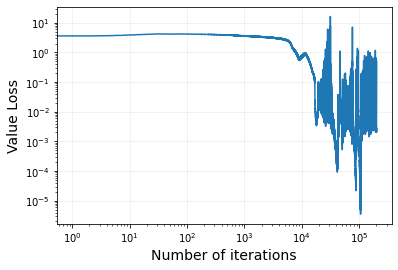

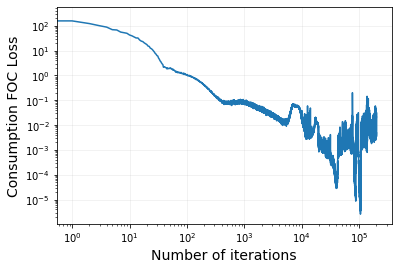

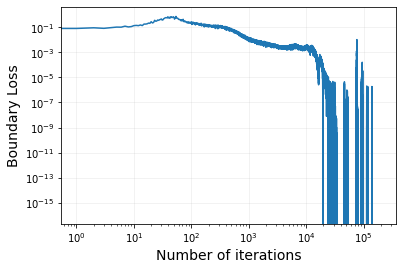

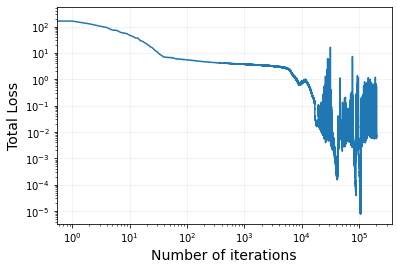

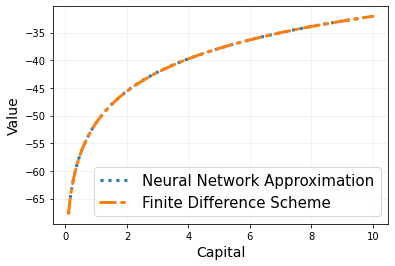

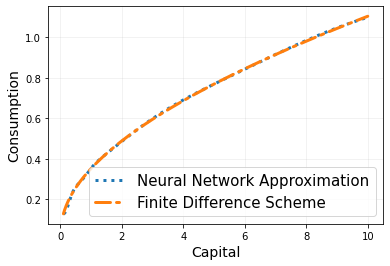

In [ ]:
###############################################################################
################################### Plotting ##################################
###############################################################################

# Define plotting grid
K = tf.cast(np.linspace(kMin, kMax, gridSize).reshape(gridSize, 1), tf.float32)

#Import reference results
reference_V = np.genfromtxt('BEN_V.csv')
reference_C = np.genfromtxt('BEN_C.csv')

#os.mkdir('results_policy_function_with_reference')
#os.chdir('results_policy_function_with_reference')

matplotlib.rcParams.update({'legend.fontsize': 15, 'axes.labelsize': 14, 'axes.titlesize': 14})
# Plot value loss function (as sqrt)
fig = plt.figure()
plt.plot(lossesV)
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif', serif = 'Computer Modern Sans serif')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Value Loss')
# plt.title('Value Loss Evolution')
plt.grid(alpha=0.2)
#fig.savefig('Value_Loss.png')

# Plot consumption FOC loss function (as sqrt)
fig = plt.figure()
plt.plot(lossesC)
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif', serif = 'Computer Modern Sans serif')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Consumption FOC Loss')
# plt.title('Consumption Loss Evolution')
plt.grid(alpha=0.2)
#fig.savefig('C_Loss.png')

# Plot boundary loss function
fig = plt.figure()
plt.plot(lossesB)
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif', serif = 'Computer Modern Sans serif')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Boundary Loss')
# plt.title('Consumption Loss Evolution')
plt.grid(alpha=0.2)
#fig.savefig('C_Loss.png')

# Plot Total loss (lossesV + lossesC + lossesB)
fig = plt.figure()
plt.plot(total_losses)
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif', serif = 'Computer Modern Sans serif')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Total Loss')
# plt.title('Consumption Loss Evolution')
plt.grid(alpha=0.2)
#fig.savefig('C_Loss.png')

# Plot value function
fig = plt.figure()
plt.plot(K, VF(K), color = "tab:blue", label = "Neural Network Approximation", linewidth = 3, linestyle=':')
plt.plot(K, reference_V, color= "tab:orange", label = "Finite Difference Scheme", linewidth = 3, linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif', serif = 'Computer Modern Sans serif')
plt.xlabel('Capital')
plt.ylabel('Value')
# plt.title('Value Function')
plt.legend(loc = "lower right")
plt.grid(alpha=0.2)
#fig.savefig('Value_Function.png')

# Plot consumption policy function
fig = plt.figure()
plt.plot(K, tf.exp(CF(K)), color = "tab:blue", label = "Neural Network Approximation", linewidth = 3, linestyle=':')
plt.plot(K, reference_C, color= "tab:orange", label = "Finite Difference Scheme", linewidth = 3, linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif', serif = 'Computer Modern Sans serif')
plt.xlabel('Capital')
plt.ylabel('Consumption')
# plt.title('Consumption Policy Function')
plt.legend(loc = "lower right")
plt.grid(alpha=0.2)
#fig.savefig('C_function.png')

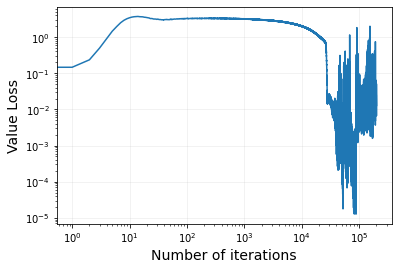

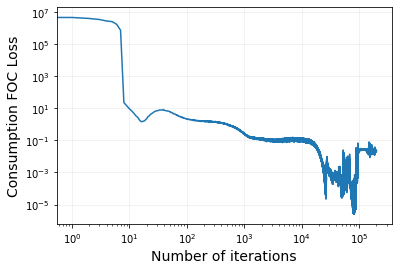

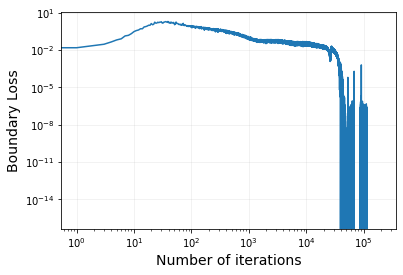

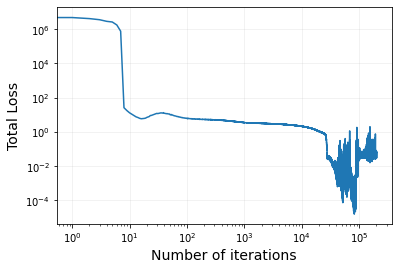

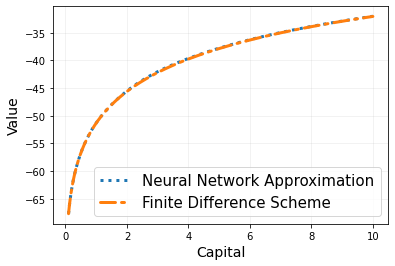

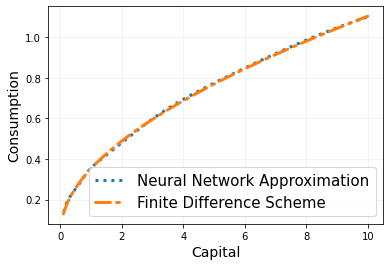

In [ ]:
###############################################################################
################################### Plotting ##################################
###############################################################################

# Define plotting grid
K = tf.cast(np.linspace(kMin, kMax, gridSize).reshape(gridSize, 1), tf.float32)

#Import reference results
reference_V = np.genfromtxt('BEN_V.csv')
reference_C = np.genfromtxt('BEN_C.csv')

#os.mkdir('results_policy_function_with_reference')
#os.chdir('results_policy_function_with_reference')

matplotlib.rcParams.update({'legend.fontsize': 15, 'axes.labelsize': 14, 'axes.titlesize': 14})
# Plot value loss function (as sqrt)
fig = plt.figure()
plt.plot(lossesV)
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif', serif = 'Computer Modern Sans serif')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Value Loss')
# plt.title('Value Loss Evolution')
plt.grid(alpha=0.2)
#fig.savefig('Value_Loss.png')

# Plot consumption FOC loss function (as sqrt)
fig = plt.figure()
plt.plot(lossesC)
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif', serif = 'Computer Modern Sans serif')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Consumption FOC Loss')
# plt.title('Consumption Loss Evolution')
plt.grid(alpha=0.2)
#fig.savefig('C_Loss.png')

# Plot boundary loss function
fig = plt.figure()
plt.plot(lossesB)
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif', serif = 'Computer Modern Sans serif')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Boundary Loss')
# plt.title('Consumption Loss Evolution')
plt.grid(alpha=0.2)
#fig.savefig('C_Loss.png')

# Plot Total loss (lossesV + lossesC + lossesB)
fig = plt.figure()
plt.plot(total_losses)
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif', serif = 'Computer Modern Sans serif')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Total Loss')
# plt.title('Consumption Loss Evolution')
plt.grid(alpha=0.2)
#fig.savefig('C_Loss.png')

# Plot value function
fig = plt.figure()
plt.plot(K, VF(K), color = "tab:blue", label = "Neural Network Approximation", linewidth = 3, linestyle=':')
plt.plot(K, reference_V, color= "tab:orange", label = "Finite Difference Scheme", linewidth = 3, linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif', serif = 'Computer Modern Sans serif')
plt.xlabel('Capital')
plt.ylabel('Value')
# plt.title('Value Function')
plt.legend(loc = "lower right")
plt.grid(alpha=0.2)
#fig.savefig('Value_Function.png')

# Plot consumption policy function
fig = plt.figure()
plt.plot(K, tf.exp(CF(K)), color = "tab:blue", label = "Neural Network Approximation", linewidth = 3, linestyle=':')
plt.plot(K, reference_C, color= "tab:orange", label = "Finite Difference Scheme", linewidth = 3, linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif', serif = 'Computer Modern Sans serif')
plt.xlabel('Capital')
plt.ylabel('Consumption')
# plt.title('Consumption Policy Function')
plt.legend(loc = "lower right")
plt.grid(alpha=0.2)
#fig.savefig('C_function.png')